In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from astropy.io import fits
import scipy
import pymaster as nmt

In [3]:
f0, f1 = '217', '217'
split0, split1 = '1', '2'
lmax = 2508
nside = 2048
lmax_beam = 3*nside # beam needs to extend to high enough ell for NaMaster

In [4]:
def get_bonus_bins(width=5, top_ell=30, l_min=2):
    bonus_bin_left, bonus_bin_right = [], []
    counter = 0
    for i in list(range(1,top_ell))[::-1]:
        counter += 1
        if i == l_min:
            bonus_bin_left.append(i)
            bonus_bin_right.append(i+width-1)
            break
        elif counter % width == 0:
            bonus_bin_left.append(i)
            bonus_bin_right.append(i+width-1)
    return bonus_bin_left[::-1], bonus_bin_right[::-1]

[2, 5, 10, 15, 20, 25]


/home/zequnl/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


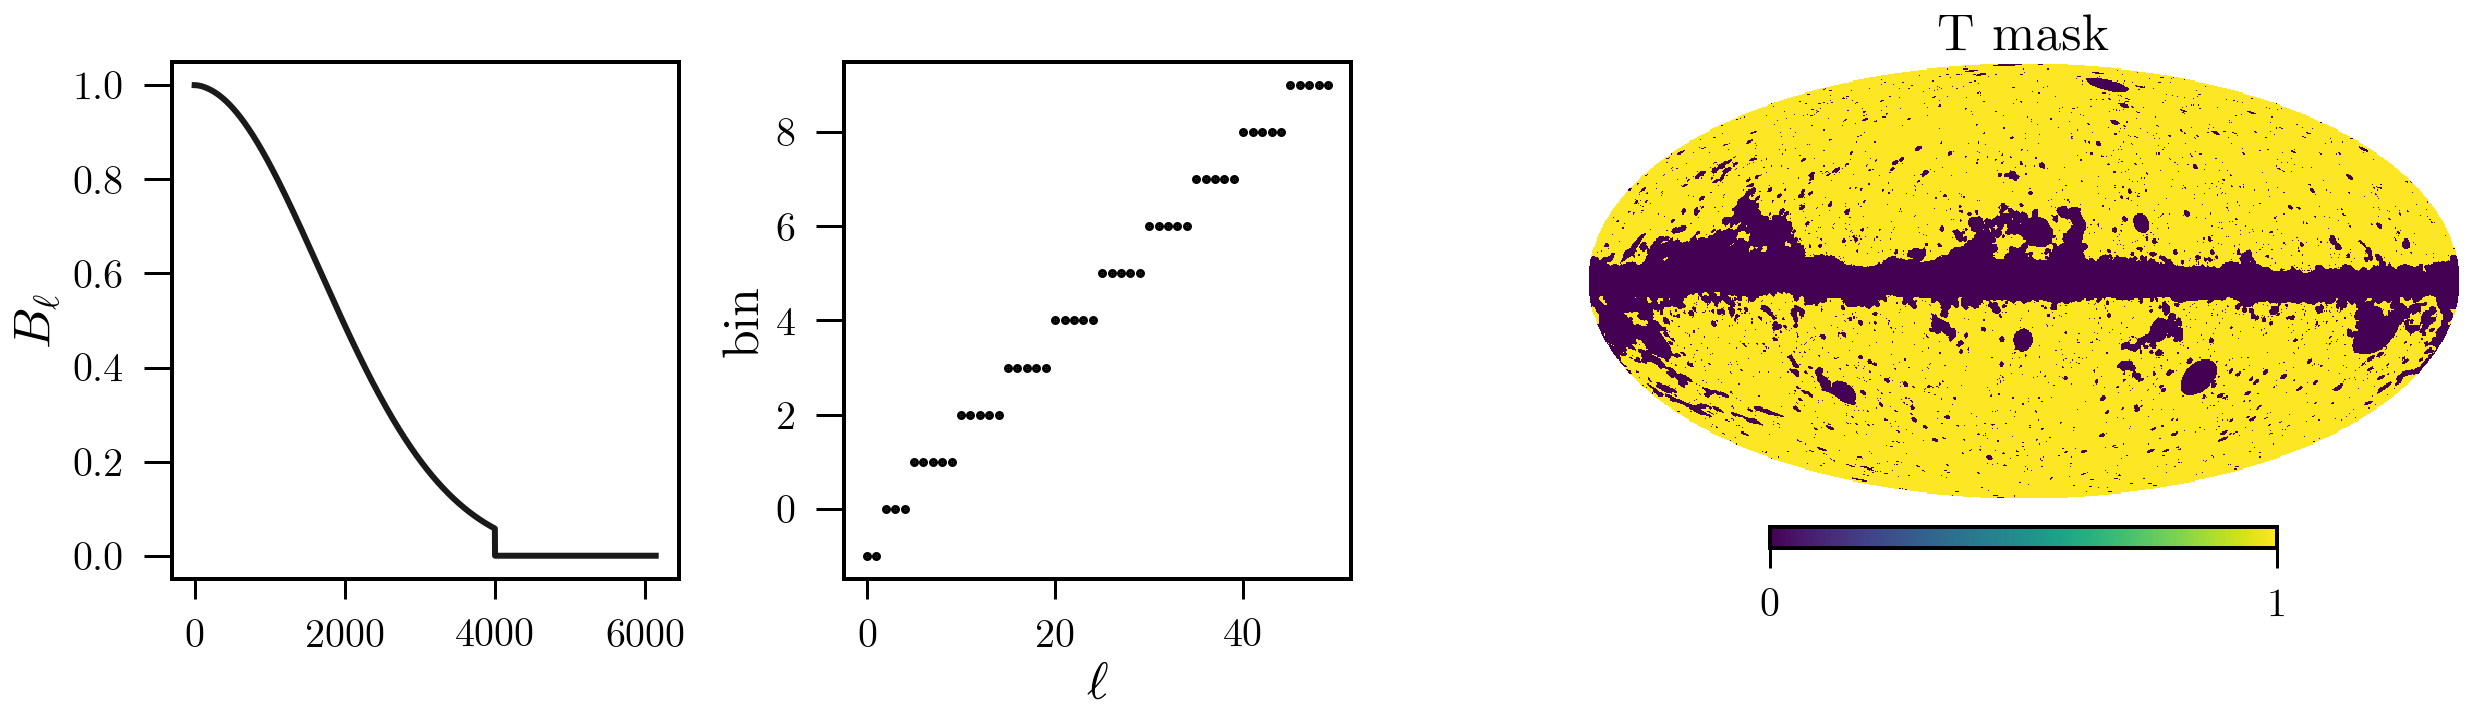

In [5]:
beam_filename = f'planck_beam/beam_likelihood_{f0}hm1x{f1}hm2.dat'
beam_ell, beam = np.genfromtxt(beam_filename, unpack=True) # beam file is ell, Bl
Bl = np.zeros(lmax_beam)
Bl[beam_ell.astype(int)] = beam

binleft, binright = np.genfromtxt('planck_spectra/binused.dat', 
                                  unpack=True, usecols=(0,1), dtype=((int), (int)))
bonus_left, bonus_right = get_bonus_bins(5, l_min=2)
print(bonus_left)
binleft, binright = np.hstack((bonus_left,binleft)), np.hstack((bonus_right,binright))
    
ells = np.arange(lmax+1)
bpws = -1+np.zeros_like(ells) #Array of bandpower indices
for i, (bl, br) in enumerate(zip(binleft, binright)):
    bpws[bl:br+1] = i
weights = np.array([l*(l+1) for l in ells])
b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=False)
lb = b.get_effective_ells()

mask0t = hp.read_map(f'PR2_CMB/COM_CMB_IQU-common-field-MaskInt_2048_R2.01.fits', verbose=False)
mask1t = mask0t #hp.read_map(f'masks/COM_Mask_Likelihood-temperature-{f1}_2048_R2.00.fits', verbose=False)


fig, ax = plt.subplots(1, 3, figsize=(18,5), gridspec_kw = {'width_ratios':[1, 1, 2]})
ax[0].plot( np.arange(lmax_beam), Bl)
ax[0].set_ylabel(r"$B_{\ell}$")
ax[1].plot(bpws[:50], 'k.')
ax[1].set_ylabel('bin')
ax[1].set_xlabel(r'$\ell$')
fig.tight_layout()

plt.sca(ax[2])
hp.mollview(mask0t, hold=True, title='T mask')

In [39]:
m0_file = f'maps/PR3/frequencyMaps/HFI_SkyMap_{f0}_2048_R3.01_halfmission-{split0}.fits'
m1_file = f'maps/PR3/frequencyMaps/HFI_SkyMap_{f1}_2048_R3.01_halfmission-{split1}.fits'

# m0_file = f'PR2_CMB/COM_CMB_IQU-143-fgsub-sevem-field-Int_2048_R2.01_halfmission-1.fits'
# m1_file = f'PR2_CMB/COM_CMB_IQU-143-fgsub-sevem-field-Int_2048_R2.01_halfmission-2.fits'

map0 = [hp.read_map(m0_file, field=0, verbose=False)] # I
map1 = [hp.read_map(m1_file, field=0, verbose=False)] # I

In [40]:
f0, split0

('217', '1')

In [41]:
# pixel_window = hp.sphtfunc.pixwin(nside, pol=False)[:len(Bl)]
pixel_window = np.load('pixwin2048.npy')

In [42]:
# NaMaster-CAR only supports niter=0
i0 = nmt.NmtField(mask0t,[map0[0]], beam=(Bl*pixel_window), n_iter=0)
i1 = nmt.NmtField(mask1t,[map1[0]], beam=(Bl*pixel_window), n_iter=0)
cl_00 = nmt.compute_full_master(i0,i1,b)

In [43]:
lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt('planck_spectra/spectra_' + f'TT_{f0}x{f1}' + '.dat',unpack=True)
ref_fac = l_ref*(l_ref+1)/(2*np.pi)
dl_ref = cl_ref * ref_fac

dl = np.interp(x=l_ref, xp=lb, fp=cl_00[0]*1e12) * ref_fac

(0, 500)

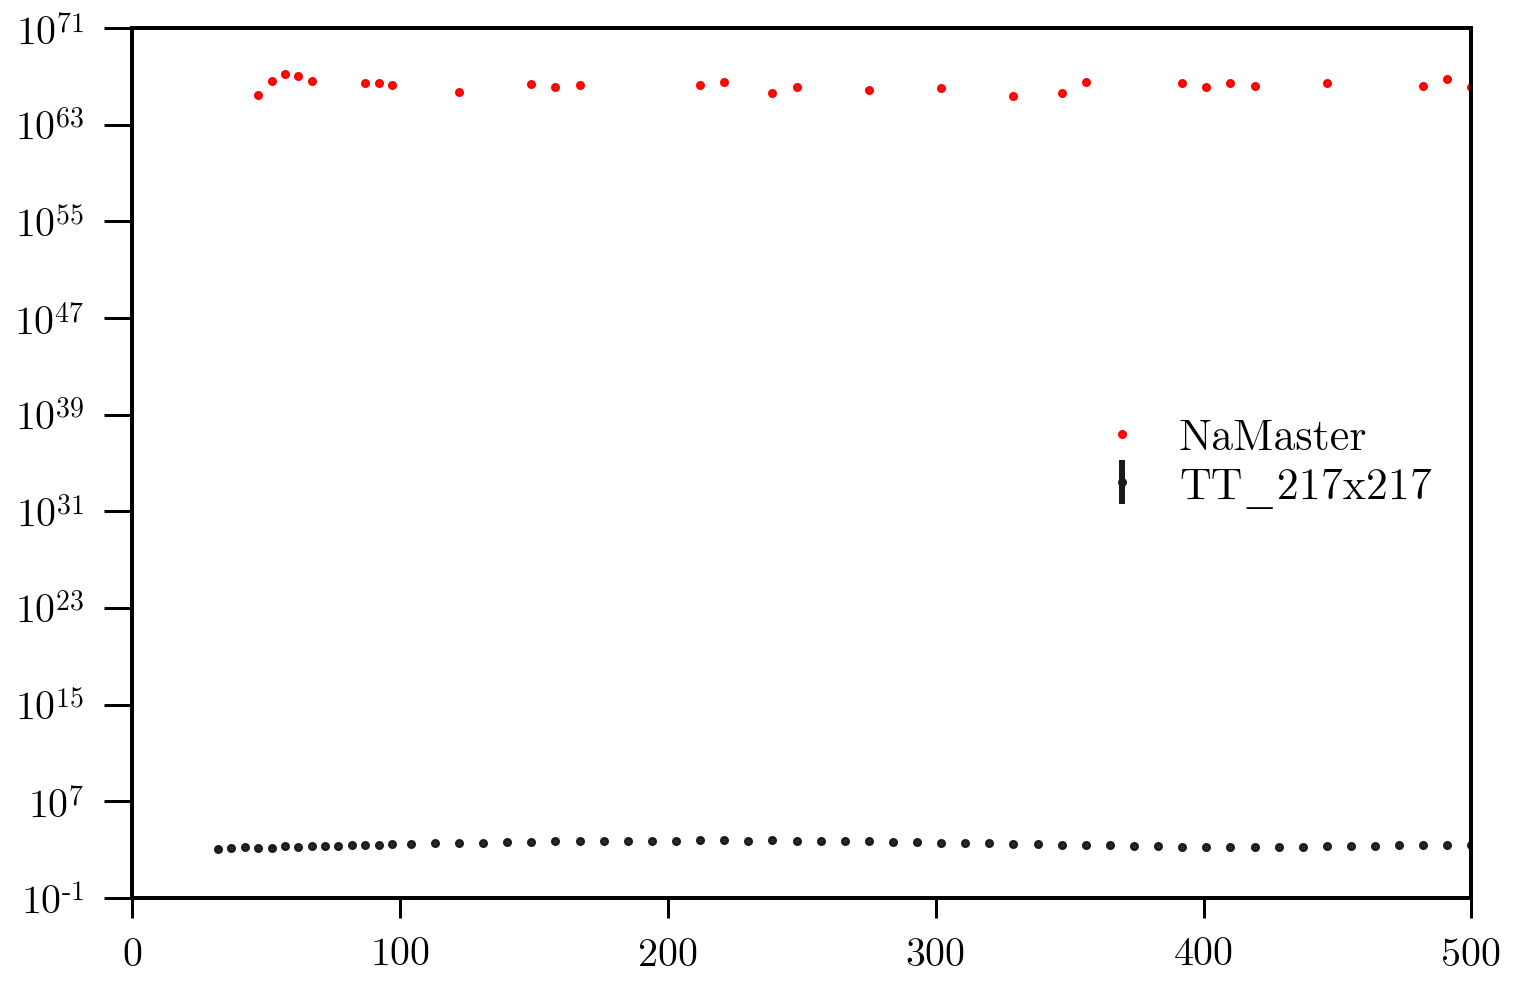

In [44]:
plt.figure(figsize=(12,8))
plt.errorbar(l_ref,dl_ref,error_ref*ref_fac,fmt='.',label='%s'%f'TT_{f0}x{f1}')
plt.plot(l_ref, dl,'r.',label=r"NaMaster")

plt.legend()
plt.yscale('log')
plt.xlim(0,500)

In [45]:
# plt.figure(figsize=(12,6))
# plt.axhline(0, color='red', alpha=0.3)
# plt.plot( l_ref,(dl / dl_ref) / Bl[l_ref.astype(int)]**4, 'k.-')
# plt.ylabel(r'$D_{\ell}^{TT} - D_{\ell}^{TT,\mathrm{ref}}$')
# plt.xlabel(r'$\ell$')

In [47]:
# plt.figure(figsize=(12,8))
# plt.errorbar(l_ref,dl_ref,error_ref*ref_fac,fmt='.',label='%s'%f'TT_{f0}x{f1}')
# plt.plot(l, dl,'r.',label=r"NaMaster")

# plt.legend()
# plt.xlim(10,500)

In [15]:
# plt.figure(figsize=(12,6))
# plt.axhline(0, color='red', alpha=0.3)
# plt.plot( l,(dl - dl_ref) / (dl_error), 'k.-')
# plt.ylabel(r'$(D_{\ell} - D_{\ell}^{\mathrm{ref}}) / \sigma_{D\ell}$')
# # plt.ylim(0.98,1.02)